# Cognition and Computation Project

## Import Libraries

In [29]:
import os
import math
import json
import random
import requests

from IPython.display import display, clear_output
from urllib.parse import quote
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import scipy
import pandas as pd
import numpy as np
import seaborn as sns

## Dataset

[The Quick, Draw! Dataset](https://github.com/googlecreativelab/quickdraw-dataset)

```quote
The Quick Draw Dataset is a collection of 50 million drawings across 345 categories, contributed by players of the game Quick, Draw!. The drawings were captured as timestamped vectors, tagged with metadata including what the player was asked to draw and in which country the player was located.
```

### Image Categories/Classes

Original 345 categories list was divided into 10 broad categories that are stored in the `categories.json` file. Broad categories are used for hierarchical sampling during dataset creation. For predicting the image class original categories are used, however, classification readout layers can be modified to predict broad categories as well.

For this project only 20 randomly selected sub-categories from different broad categories are used with 2000 samples per sub-category. Performance of the model may vary with more selective choice of sub-categories and different number of sub-categories.

In [2]:
DATASET_BASE_URL = "https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"
IMG_SHAPE = (28, 28)
BATCH_SIZE = 32

RANDOM_SEED = 42
CLASS_NUM = 20
SAMPLES_PER_CLASS = 2000

categories_json_filename = 'categories.json'

In [3]:
%%capture

# Downloading categories
!wget -O {categories_json_filename} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/data/{categories_json_filename}"

In [4]:
categories_json = {}
with open(categories_json_filename, 'r') as f:
    categories_json = json.load(f)

# display(categories_json)

In [5]:
def get_quickdraw_data(categories_json, total_classes=5, samples_per_class=2000, seed=123):
    """
    categories_json: dict {SuperCategory: [list of subcategories]}
    total_classes: total number of classes to sample
    samples_per_class: number of samples to download per class
    """
    selected_classes = []

    random.seed(seed)

    # 1. Hierarchical Sampling
    pool = {k: list(v) for k, v in categories_json.items()}
    while len(selected_classes) < total_classes:
        broad_cats = [c for c, items in pool.items() if len(items) > 0]
        if not broad_cats:
            break

        # Uniformly select broad category
        broad_cat = random.choice(broad_cats)

        # Uniformly sample sub-category
        sub_cat = random.choice(pool[broad_cat])

        selected_classes.append((sub_cat, broad_cat))

        # Exclude sampled sub-category
        pool[broad_cat].remove(sub_cat)

    # 2. Downloading data
    X, Y, Y_super = [], [], []

    for i, (sub_cat, broad_cat) in enumerate(selected_classes):
        file_name = f'{quote(sub_cat)}.npy'
        url = DATASET_BASE_URL + file_name

        print(f'Downloading {sub_cat} ({broad_cat})...')
        res = requests.get(url)
        data = np.frombuffer(
            res.content, dtype=np.uint8, offset=80
        )
        data = data.reshape(-1, math.prod(IMG_SHAPE))[:samples_per_class]

        X.append(data)
        Y.append(np.full(len(data), i))  # Sub-class label (from 0 to total_classes-1)

        # Numerical label for broad category
        Y_super.append(
            [list(categories_json.keys()).index(broad_cat)] * len(data)
        )

    X = np.concatenate(X) / 255.0  # Normalize [0,1]
    Y = np.concatenate(Y)

    return torch.FloatTensor(X), torch.LongTensor(Y), selected_classes

In [ ]:
%%capture

# Downloading previously used data
quickdraw_data_filename = 'quickdraw_data.npz'

!wget -O {quickdraw_data_filename} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/data/{quickdraw_data_filename}"

loaded_data = np.load(quickdraw_data_filename, allow_pickle=True)

sketch_data = torch.from_numpy(loaded_data['data'])
sketch_labels = torch.from_numpy(loaded_data['labels'])
sketch_categories = loaded_data['categories'].tolist()

In [6]:
# Sampling new data
sketch_data, sketch_labels, sketch_categories = get_quickdraw_data(
    categories_json, total_classes=CLASS_NUM, samples_per_class=SAMPLES_PER_CLASS, seed=RANDOM_SEED
)

In [ ]:
# Saving sampled data
quickdraw_data_filename = 'quickdraw_data.npz'

save_data = sketch_data.numpy()
save_labels = sketch_labels.numpy()
save_categories = np.array(sketch_categories, dtype=object)

np.savez_compressed(
    quickdraw_data_filename,
    data=save_data,
    labels=save_labels,
    categories=save_categories
)

In [7]:
def show_img(
    img, sub_category=None, broad_category=None, predicted_sub_category=None, predicted_broad_category=None
):
    if sub_category is not None:
        print(f'Sub-category: {sub_category}')
    if broad_category is not None:
        print(f'Broad category: {broad_category}')
    if predicted_sub_category is not None:
        print(f'Predicted sub-category: {predicted_sub_category}')
    if predicted_broad_category is not None:
        print(f'Predicted broad category: {predicted_broad_category}')
    img = img.cpu()
    plt.imshow(img, cmap='gray')
    plt.show()


def compare_imgs(imgs, sub_category, broad_category):
    print(f'Sub-category: {sub_category}')
    print(f'Broad category: {broad_category}')
    n_imgs = len(imgs)
    for i, img in enumerate(imgs):
        img = img.cpu()
        plt.subplot(1, n_imgs, i+1)
        plt.imshow(img, cmap='gray')
    plt.show()


def show_class_distribution(labels, categories):
    counts = pd.Series(labels.numpy()).value_counts().sort_index()

    df_meta = pd.DataFrame(
        categories, columns=['sub_category', 'broad_category']
    )
    df_meta['samples'] = counts.values

    sns.set_theme(style='whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    sns.barplot(
        data=df_meta,
        x='sub_category', y='samples', hue='broad_category',
        palette='viridis', dodge=False, legend=False, ax=axes[0]
    )
    axes[0].set_title('Samples per Sub-Category')
    axes[0].tick_params(axis='x', rotation=45)

    sns.barplot(
        data=df_meta.groupby('broad_category')['samples'].sum().reset_index(),
        x='broad_category', y='samples', hue='broad_category',
        palette='magma', legend=False, ax=axes[1]
    )
    axes[1].set_title('Samples per Broad Category')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

Sub-category: aircraft carrier
Broad category: Transport


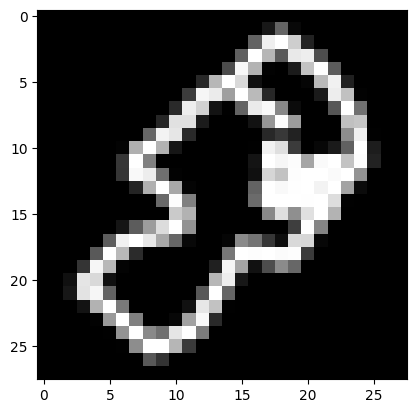

In [9]:
img_idx = 1501
img = sketch_data[img_idx]
label = sketch_labels[img_idx]
sub_category, broad_category = sketch_categories[label]

show_img(
    img.reshape(IMG_SHAPE),
    sub_category=sub_category,
    broad_category=broad_category
)

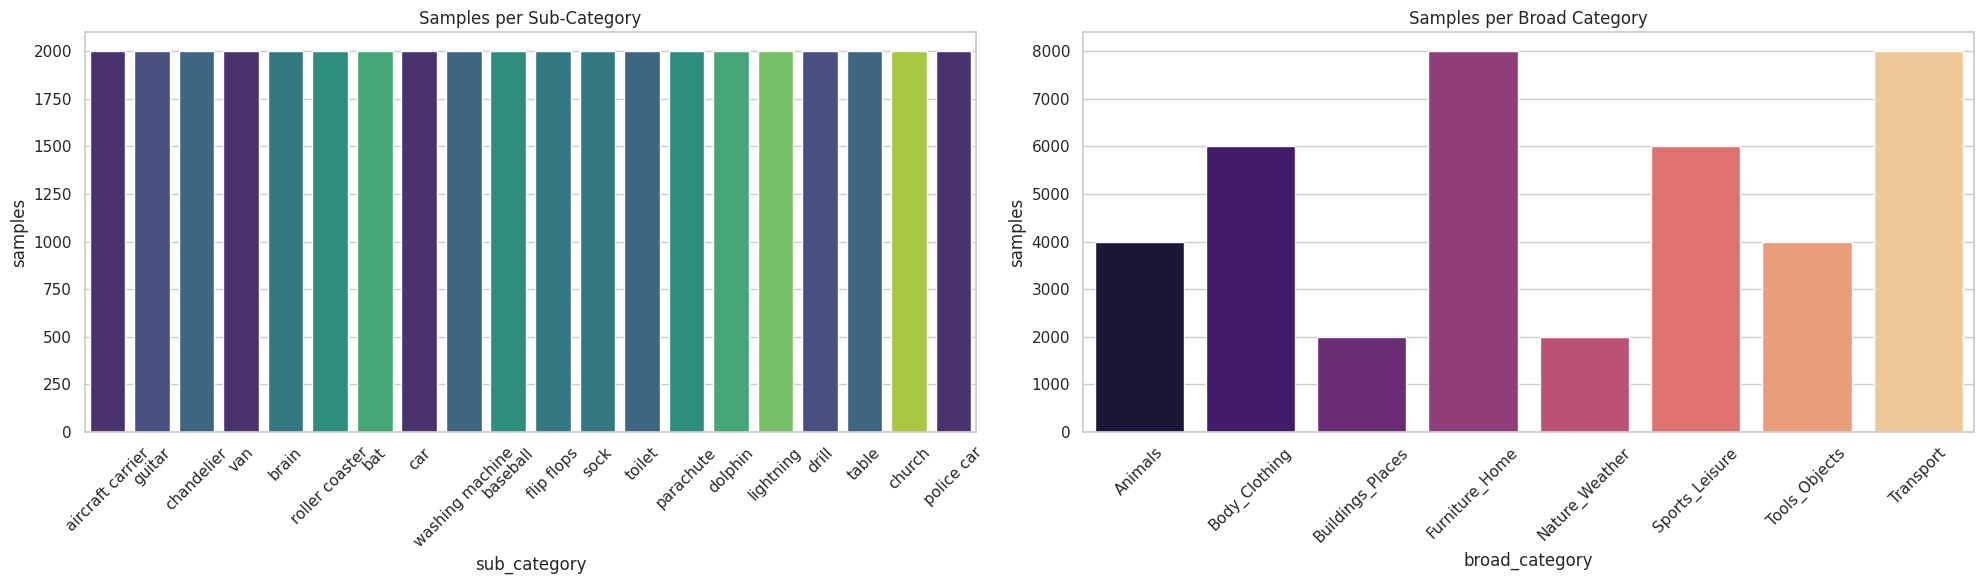

In [8]:
show_class_distribution(sketch_labels, sketch_categories)

In [9]:
# Create train and test dataloaders
train_size = int(0.8 * len(sketch_data))
test_size = len(sketch_data) - train_size

train_data, test_data = torch.utils.data.random_split(
    sketch_data, [train_size, test_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

train_labels, test_labels = torch.utils.data.random_split(
    sketch_labels, [train_size, test_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED)
)

train_dataset = TensorDataset(
    train_data.dataset[train_data.indices],
    train_labels.dataset[train_labels.indices]
)
test_dataset = TensorDataset(
    test_data.dataset[test_data.indices],
    test_labels.dataset[test_labels.indices]
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Training dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_name)

print(f'Using device: {device_name}')

Training dataset size: 32000
Test dataset size: 8000
Using device: cpu


## Training

Universal utils functions for training and loading the Pytorch models. Train function supports both self-supervised (for VAE) and supervised training (for classification linear readout).

No hyperparameter tuning was performed for any of the models. However, different learning rates, batch sizes and regularization parameters could be explored to improve the model performance.

In [10]:
def train_model(
    model, train_loader, optimizer_cls, loss_fn, optimizer_params={}, self_supervised=False, epochs=10,
    device=None, filename=None, checkpoint_freq=5, checkpoint_dir=None, checkpoint_path=None
):
    model.to(device)

    start_epoch = 0

    optimizer = optimizer_cls(model.parameters(), **optimizer_params)

    if checkpoint_path is not None:
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=device)

            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            start_epoch = checkpoint['epoch']
            loss = checkpoint['loss']

            # Override optimizer params
            for group in optimizer.param_groups:
                for k, v in optimizer_params.items():
                    if k != 'params':
                        group[k] = v

            print(f'Resumed from epoch {start_epoch}, Loss: {loss:.4f}')

    for epoch in range(start_epoch, epochs):
        model.train()

        running_loss = 0.0
        n_samples = 0

        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device) if not self_supervised else data.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_fn(outputs, targets)

            running_loss += loss.item()
            n_samples += data.size(0)

            loss.backward()
            optimizer.step()

        epoch_loss = running_loss / n_samples

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

        if checkpoint_dir and (epoch + 1) % checkpoint_freq == 0:
            checkpoint_path = os.path.join(
                checkpoint_dir,
                f'{filename}_check_{epoch+1}.pth'
            )
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_loss,
            }, checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

    if filename is not None:
        file_path = f'{filename}.pth'
        torch.save(model.state_dict(), file_path)
        print(f'Model weights saved to "{file_path}"')

    return model


def load_model(model, file_path, download=True, from_checkpoint=False, device=None):

    if download:
        !wget -O {file_path} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/models/{file_path}"

    state_file = torch.load(file_path, map_location=device)
    if from_checkpoint:
        model.load_state_dict(state_file['model_state_dict'])
    else:
        model.load_state_dict(state_file)

    model.to(device)
    print(f'Model weights loaded from "{file_path}"')
    return model

## Variational Autoencoder (VAE)

[An Introduction to Variational Autoencoders. Diederik P. Kingma, Max Welling](https://arxiv.org/pdf/1906.02691)

![VAE Architecture](https://upload.wikimedia.org/wikipedia/commons/1/11/Reparameterized_Variational_Autoencoder.png)

### Objective Function

$$ELBO = \underbrace{\mathbb{E}_{q_\phi(z|x)}[\log p_\theta(x|z)]}_{\text{Reconstruction Log-Likelihood}} - \underbrace{D_{KL}(q_\phi(z|x) || p(z))}_{\text{KL Divergence Regularizer}}$$

KL Divergence Regularizer

$$D_{KL} = -\frac{1}{2} \sum_{j=1}^J (1 + \log(\sigma_j^2) - \mu_j^2 - \sigma_j^2)$$

The goal of a VAE is to maximize the ELBO. In practice, we minimize the Negative ELBO as a loss function.


### Implementation details

Implemented VAE consists of an encoder and a decoder with fully connected layers. Data samples are normalized to [0, 1] and flattened from 28×28 to a 784 size vector before being passed to the network.

**Encoder:**
- Input: 784
- Hidden: 784 → 512 → 256 with ReLU activations
- Two parallel linear heads produce the parameters of the approximate posterior:
  - μ(x): 256 → 32
  - log σ²(x): 256 → 32

**Decoder:**
- Hidden: 32 → 256 → 512 → 784 with ReLU activations
- Output activation: Sigmoid, matching the normalized pixel range and enabling a Bernoulli-style reconstruction objective.

In [11]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [12]:
def recon_log_likelihood(recon_x, x):
    return -F.binary_cross_entropy(recon_x, x, reduction='sum')


def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())


def elbo(recon_x, x, mu, logvar):
    return recon_log_likelihood(recon_x, x) - kl_divergence(mu, logvar)


def vae_loss_fn(outputs, x):
    recon_x, mu, logvar = outputs
    return -elbo(recon_x, x, mu, logvar)

In [13]:
vae_model = VAE(
    input_dim=IMG_SHAPE[0] * IMG_SHAPE[1],
    hidden_dim=512,
    latent_dim=32
)
optimizer_cls = torch.optim.Adam
optimizer_params = {'lr': 0.001}

num_linear_layers = len([m for m in vae_model.encoder if isinstance(m, nn.Linear)]) + 1

In [16]:
# Training VAE
vae_model = train_model(
    model=vae_model,
    train_loader=train_loader,
    optimizer_cls=optimizer_cls,
    optimizer_params=optimizer_params,
    loss_fn=vae_loss_fn,
    self_supervised=True,
    epochs=300,
    device=device,
    filename='vae_model',
    checkpoint_freq=100,
    checkpoint_dir='checkpoints',
    # checkpoint_path='checkpoints/vae.pth_check_250.pth'
)

Epoch 1/300, Loss: 287.9083
Epoch 11/300, Loss: 227.7480
Epoch 21/300, Loss: 224.0305
Epoch 31/300, Loss: 222.2869
Epoch 41/300, Loss: 221.2115
Epoch 51/300, Loss: 220.4508
Epoch 61/300, Loss: 219.8090
Epoch 71/300, Loss: 219.3725
Epoch 81/300, Loss: 218.9618
Epoch 91/300, Loss: 218.6730
Checkpoint saved: checkpoints/vae_model_check_100.pth
Epoch 101/300, Loss: 218.3870
Epoch 111/300, Loss: 218.1768
Epoch 121/300, Loss: 217.9579
Epoch 131/300, Loss: 217.7953
Epoch 141/300, Loss: 217.5779
Epoch 151/300, Loss: 217.4513
Epoch 161/300, Loss: 217.2720
Epoch 171/300, Loss: 217.1730
Epoch 181/300, Loss: 217.0130
Epoch 191/300, Loss: 216.8813
Checkpoint saved: checkpoints/vae_model_check_200.pth
Epoch 201/300, Loss: 216.8130
Epoch 211/300, Loss: 216.7004
Epoch 221/300, Loss: 216.6604
Epoch 231/300, Loss: 216.5358
Epoch 241/300, Loss: 216.4754
Epoch 251/300, Loss: 216.4306
Epoch 261/300, Loss: 216.3162
Epoch 271/300, Loss: 216.3076
Epoch 281/300, Loss: 216.2095
Epoch 291/300, Loss: 216.1225
Epo

In [14]:
%%capture

# Loading VAE
vae_model = load_model(
    model=vae_model,
    file_path='vae_model.pth',
    download=True,
    from_checkpoint=False,
    device=device
)

Sub-category: roller coaster
Broad category: Sports_Leisure


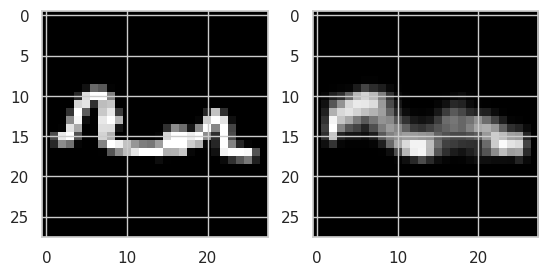

In [59]:
test_idx = 1000
test_img, test_label = test_dataset[test_idx]
test_sub_category, test_broad_category = sketch_categories[test_label]

recon_img, _, _ = vae_model(test_img.to(device))

compare_imgs(
    [img.reshape(IMG_SHAPE) for img in [test_img, recon_img.detach()]],
    sub_category=test_sub_category,
    broad_category=test_broad_category
)

## Visualizing receptive fields

To visualize receptive fields in a VAE, we use a linear projection method that collapses the encoder layers into a single weight matrix. This allows to build projection from each hidden layer to input pixels.

Layer 1. Some receptive fields act as edge detectors. They respond to simple local shapes, forms in specific parts of the image.

Layer 2. These fields are more complex and combine the edges from Layer 1 into parts or shapes.

Layer 3. These are global templates that may look like entire objects. They represent the "concepts" the VAE has learned from training data.

In [15]:
def get_effective_weights(model, layer_idx=None):
    weights = []

    # Input -> Linear -> fc_mu -> Latent
    for m in model.encoder:
        if isinstance(m, nn.Linear):
            weights.append(m.weight.data)
    weights.append(model.fc_mu.weight.data)

    eff_w = weights[0]
    for i in range(1, layer_idx + 1):
        eff_w = torch.mm(weights[i], eff_w)

    return eff_w   # [input_dim, latent_dim]


def plot_fields(weights, title, img_shape, max_plots=16):
    total_available = weights.shape[0]
    n_plots = min(total_available, max_plots)

    n_cols = math.ceil(math.sqrt(n_plots))
    n_rows = math.ceil(n_plots / n_cols)

    fig, axs = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5)
    )
    fig.suptitle(title, fontsize=16, y=1.01)

    for i in range(n_plots):
        ax = axs[i // n_cols, i % n_cols]

        field = weights[i, :].view(img_shape).cpu().numpy()

        im = ax.imshow(field, cmap='RdBu_r')
        ax.axis('off')
        ax.set_title(f'{i}')

    plt.tight_layout()
    plt.show()

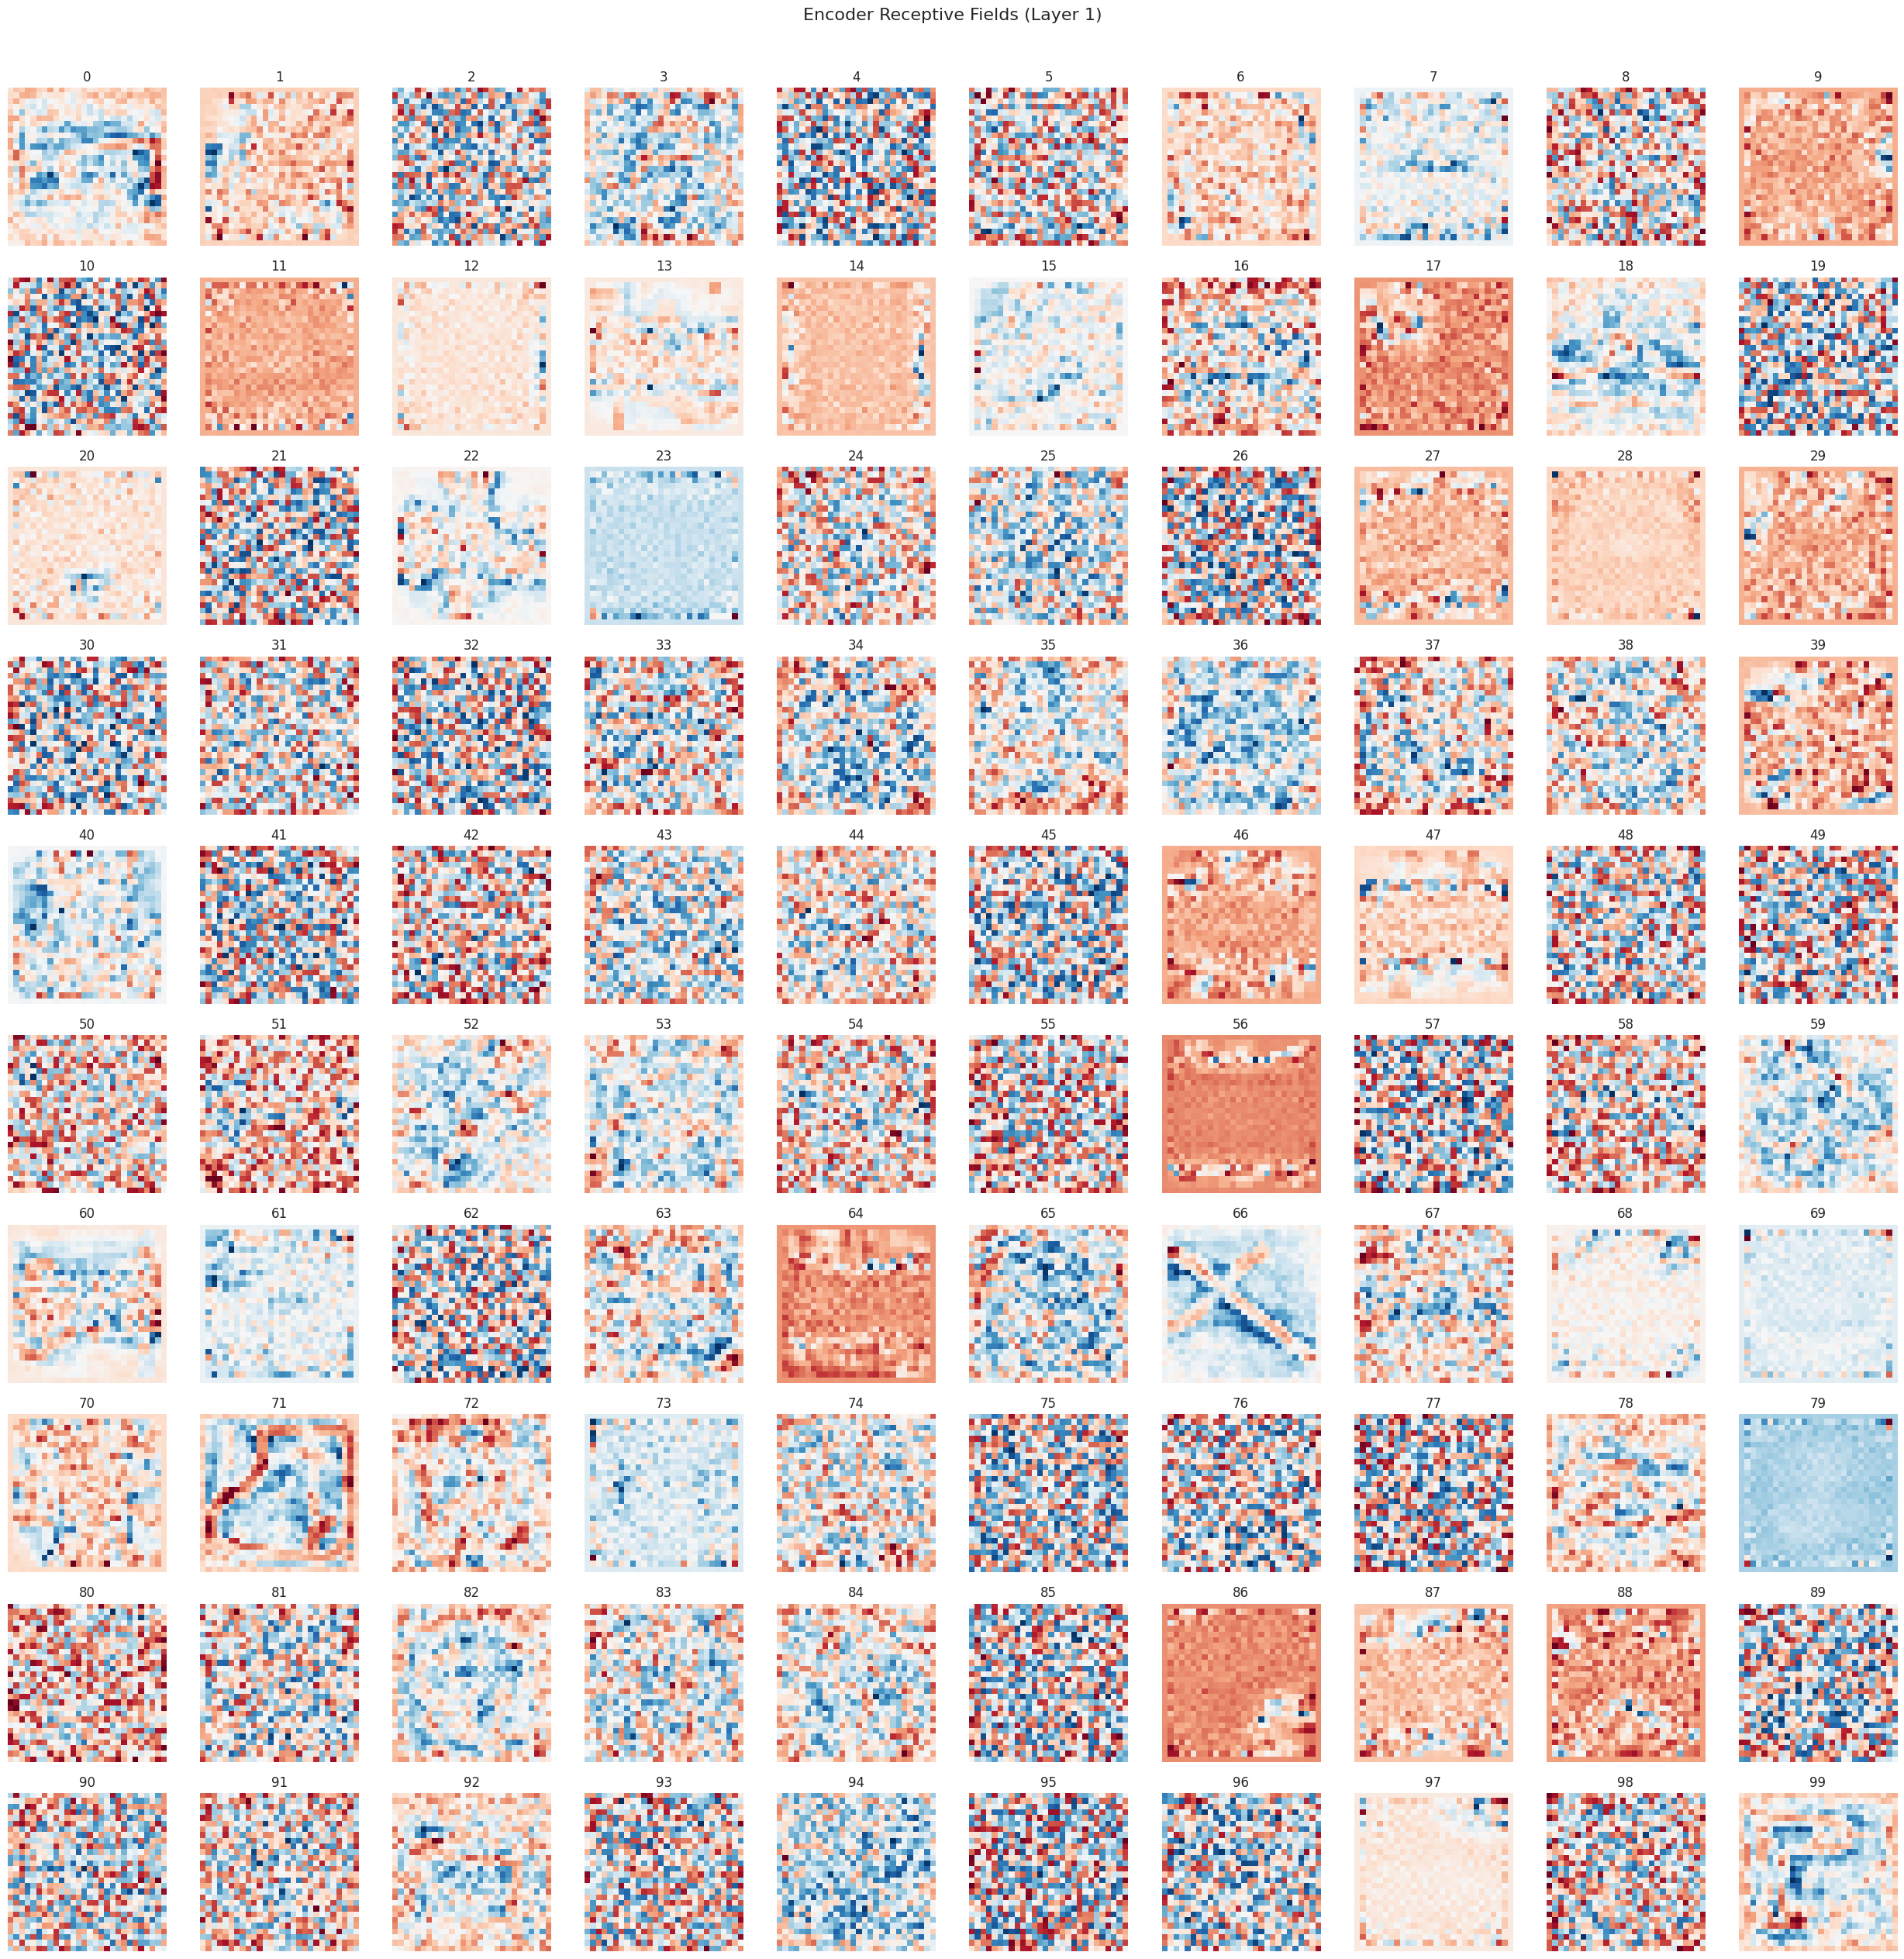

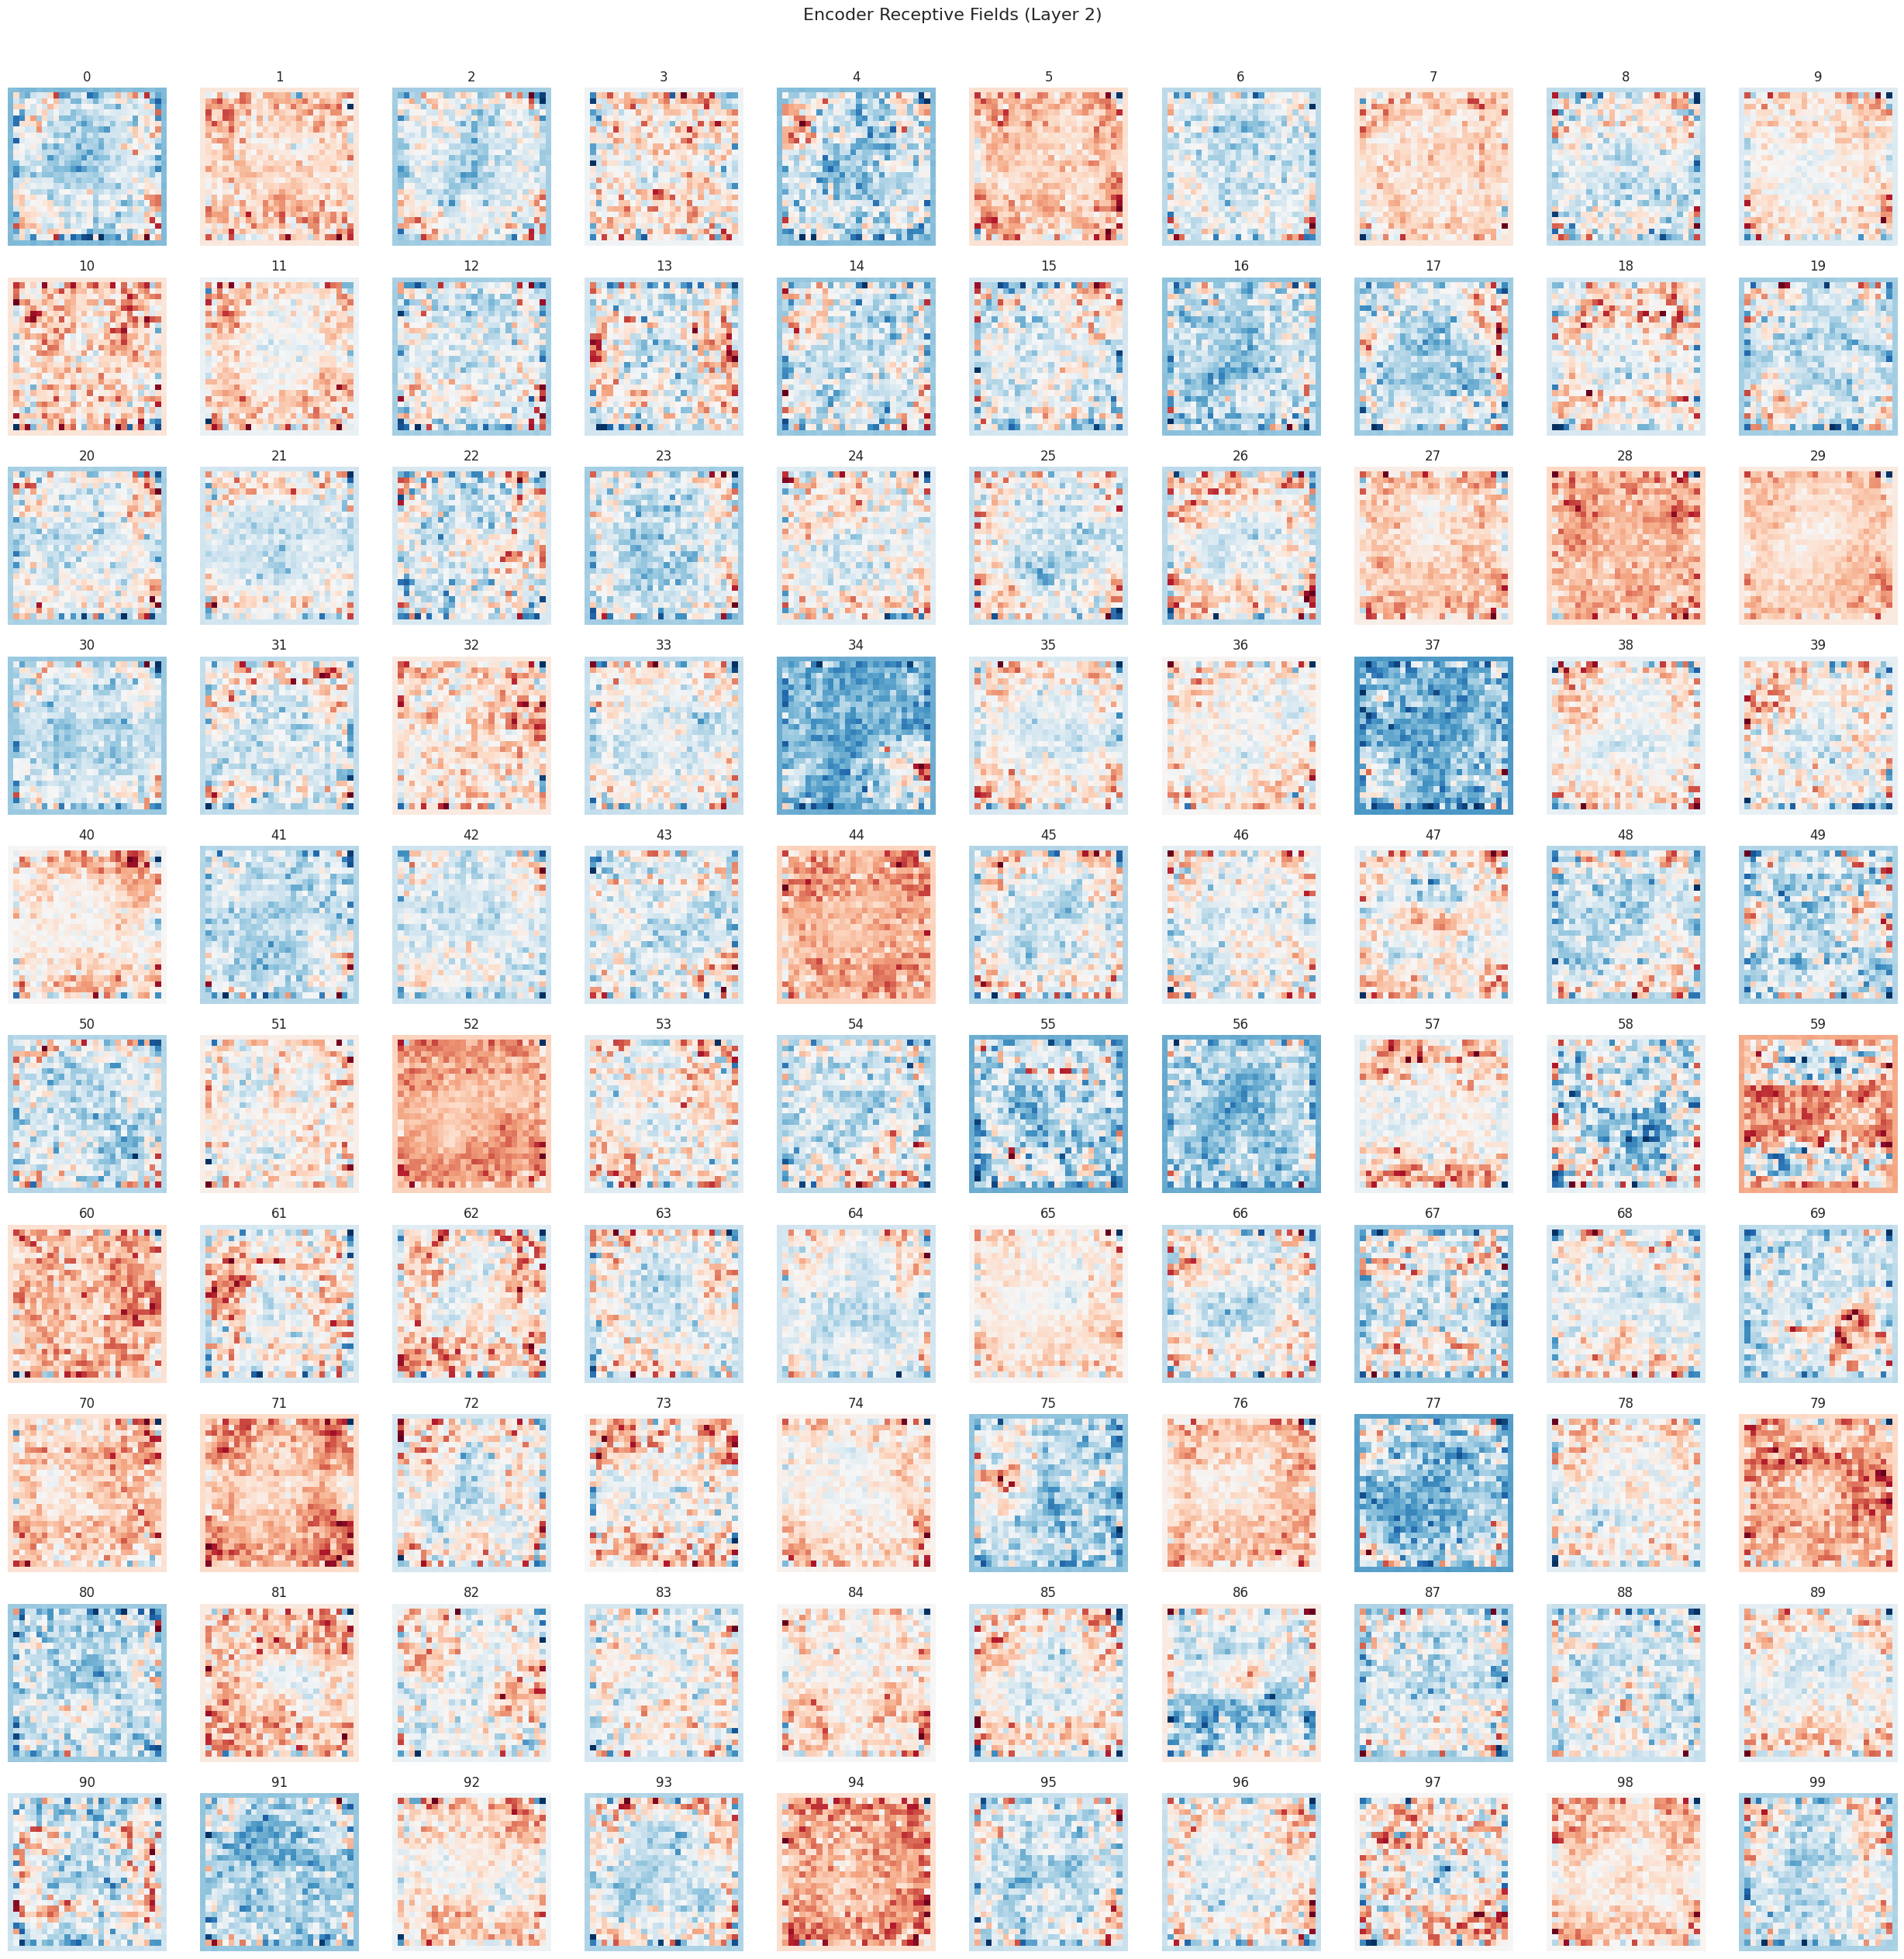

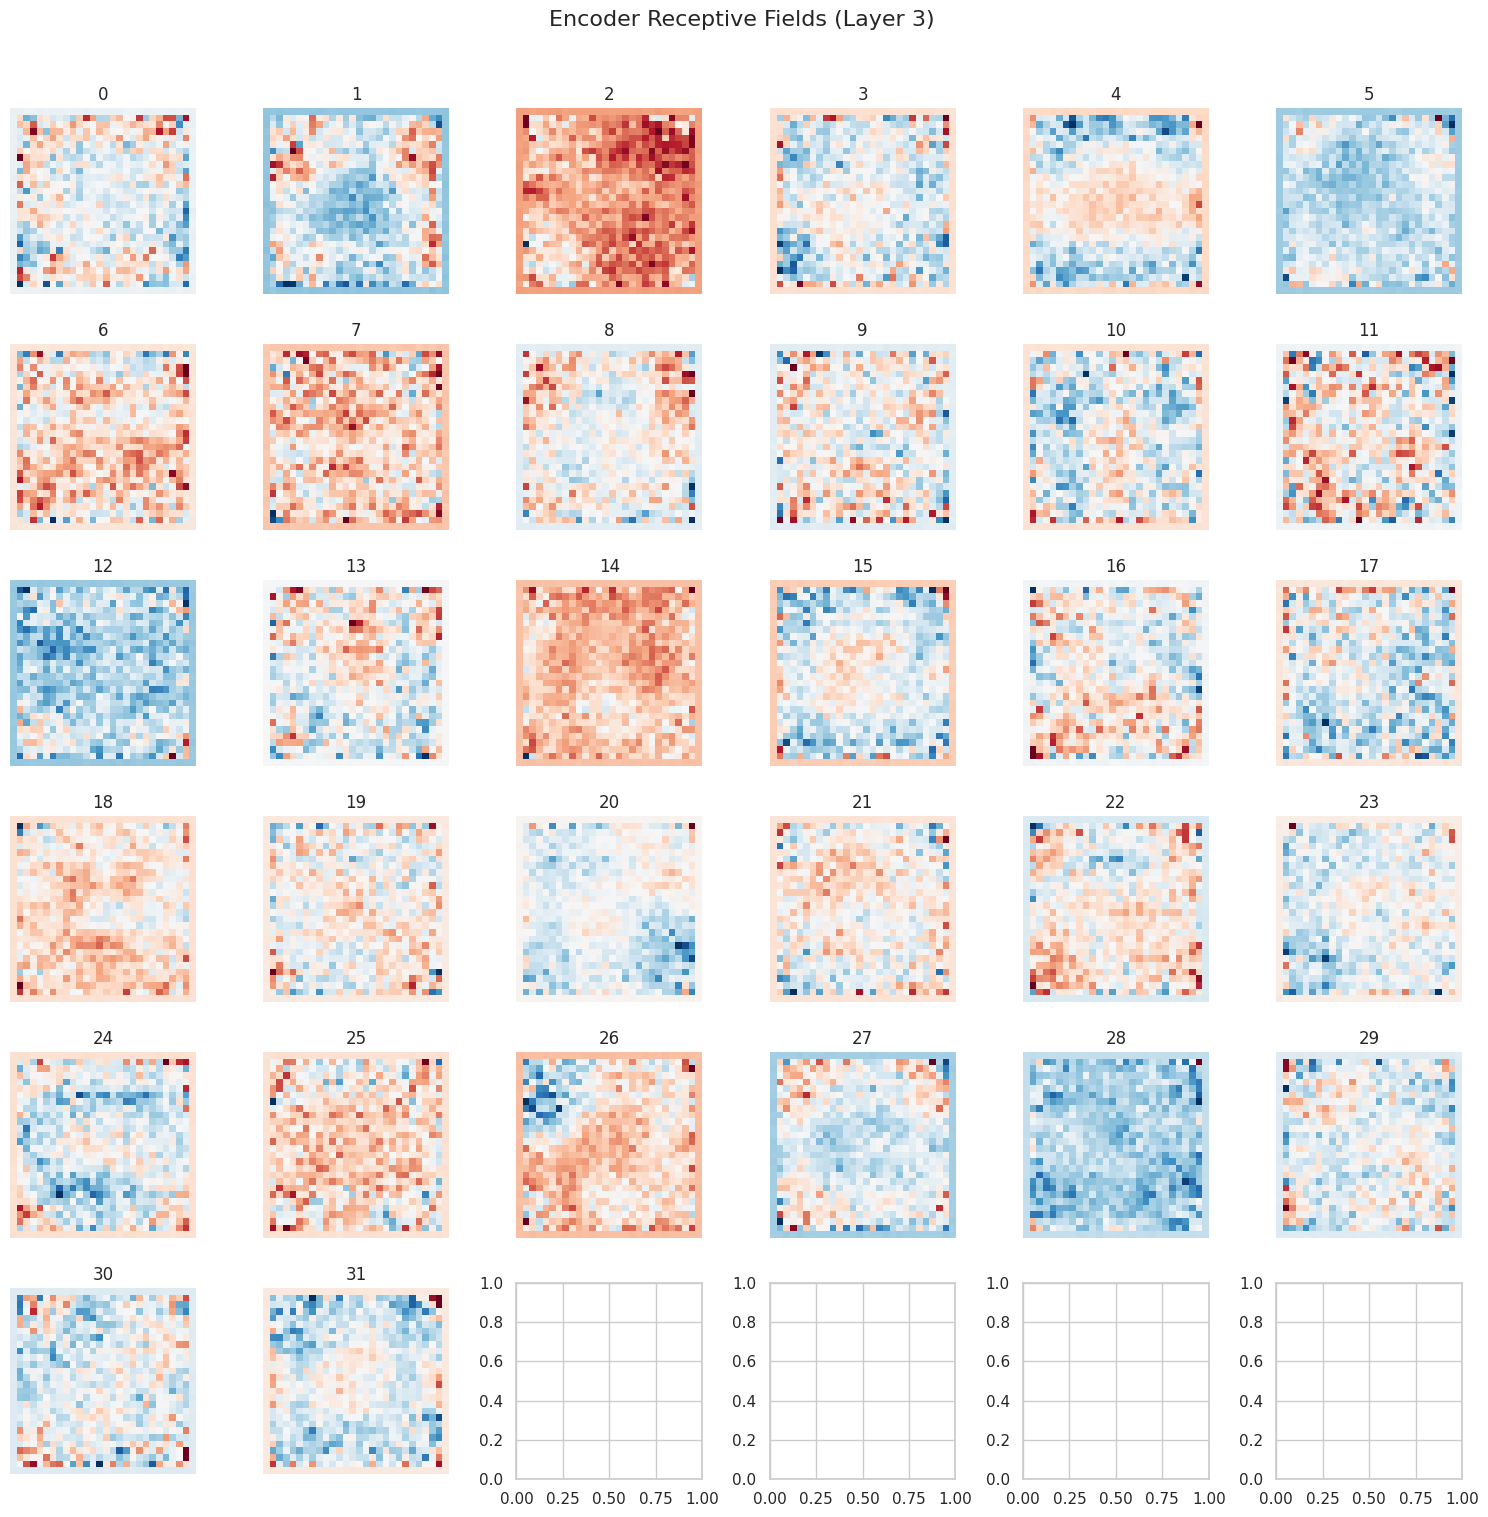

In [16]:
for layer_idx in range(num_linear_layers):
    enc_w = get_effective_weights(
        vae_model, layer_idx=layer_idx
    )
    plot_fields(
        enc_w, f'Encoder Receptive Fields (Layer {layer_idx+1})', IMG_SHAPE, max_plots=100
    )

## Clustering internal representations

To evaluate how the VAE organizes information, the mean latent representations of each class are visualized using t-SNE and Hierarchical Clustering.

The t-SNE projection maps the latent space into 2 dimensions. Shows success of the encoder: semantically related objects (like car, police car, van) are placed in the same neighborhood. But since t-SNE is a non-linear projection, distances between clusters may not reflect true similarity.

The dendrogram gives insights at the encoder’s internal hierarchy by showing how classes branch together. Same as for t-SNE, related objects cluster together (see vehicles). The height of branches indicates how similar classes are in latent space. 

In [27]:
def get_mean_representations(representations, labels):
    return {
        label: np.mean(representations[labels == label], axis=0)
        for label in np.unique(labels)
    }


def show_clusters(representations, labels, categories):
    mean_representations = get_mean_representations(representations, labels)
    unique_labels = sorted(mean_representations.keys())

    representations_matrix = np.stack([
        mean_representations[label] for label in unique_labels
    ])

    tsne = TSNE(
        n_components=2,
        perplexity=5,
        learning_rate='auto',
        init='pca',
        random_state=RANDOM_SEED
    )
    tsne_result = tsne.fit_transform(representations_matrix)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.scatter(
        tsne_result[:, 0], tsne_result[:, 1],
        s=150, c='royalblue', edgecolors='white', alpha=0.8
    )

    for i, label in enumerate(unique_labels):
        sub_category = categories[label][0]
        plt.annotate(
            sub_category,
            (tsne_result[i, 0], tsne_result[i, 1]),
            xytext=(8, 8),
            textcoords='offset points',
            fontsize=10,
            fontweight='bold',
            bbox=dict(
                boxstyle='round,pad=0.4', facecolor='yellow',
                alpha=0.7, edgecolor='black'
            )
        )

    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


def show_dendrogram(
    representations, labels, categories
):
    mean_representations = get_mean_representations(representations, labels)
    unique_labels = sorted(mean_representations.keys())
    representations_matrix = np.concatenate([
        np.expand_dims(mean_representations[label], axis=0)
        for label in unique_labels
    ])

    fig, ax = plt.subplots(figsize=(14, 8))
    linkage = scipy.cluster.hierarchy.linkage(
        representations_matrix, method='complete'
    )

    dendrogram_labels = [categories[label][0] for label in unique_labels]

    dendrogram = scipy.cluster.hierarchy.dendrogram(
        linkage,
        labels=dendrogram_labels,
        leaf_rotation=45,
        leaf_font_size=12
    )

    plt.tight_layout()
    plt.show()

======= Latent Space =======


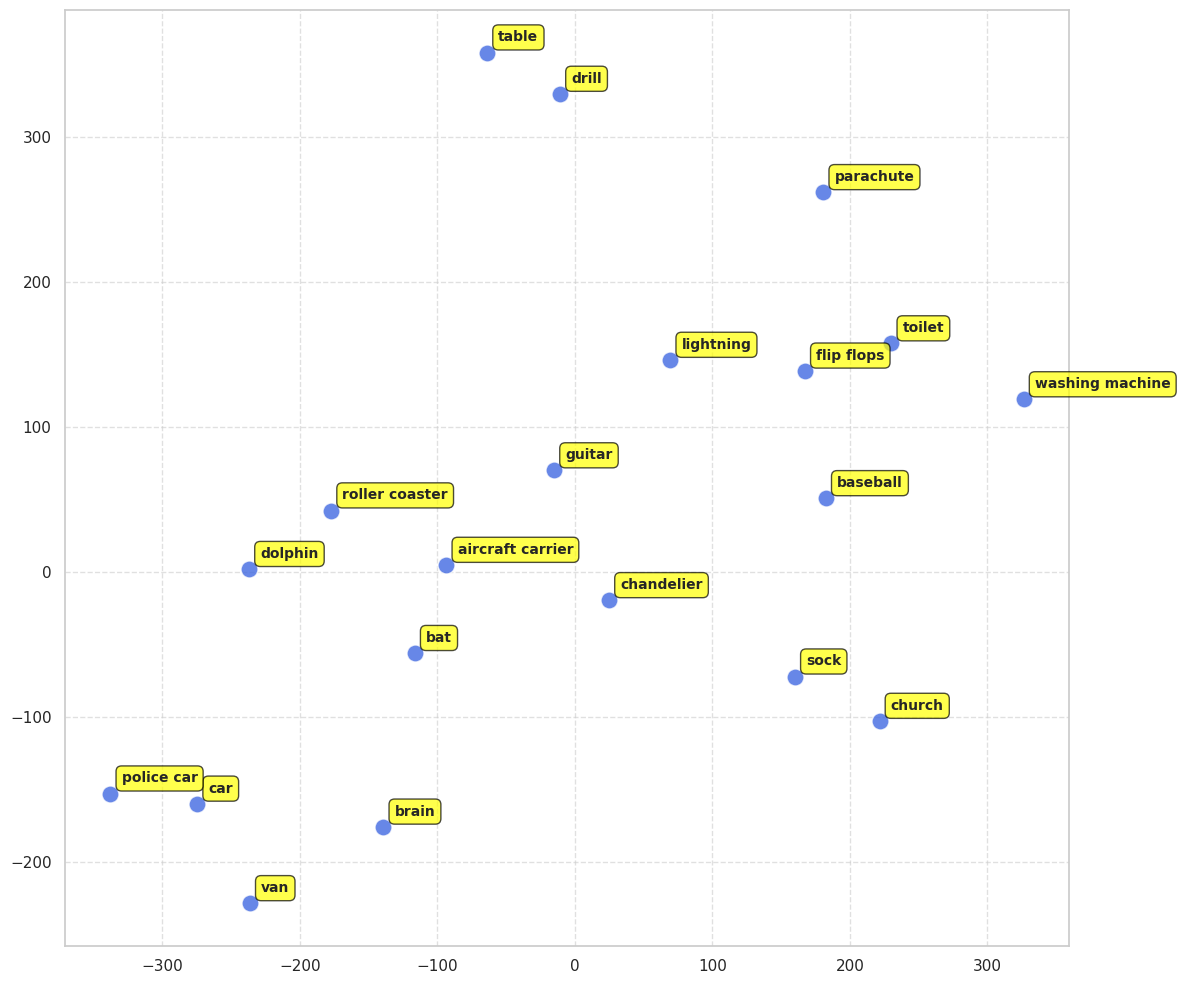

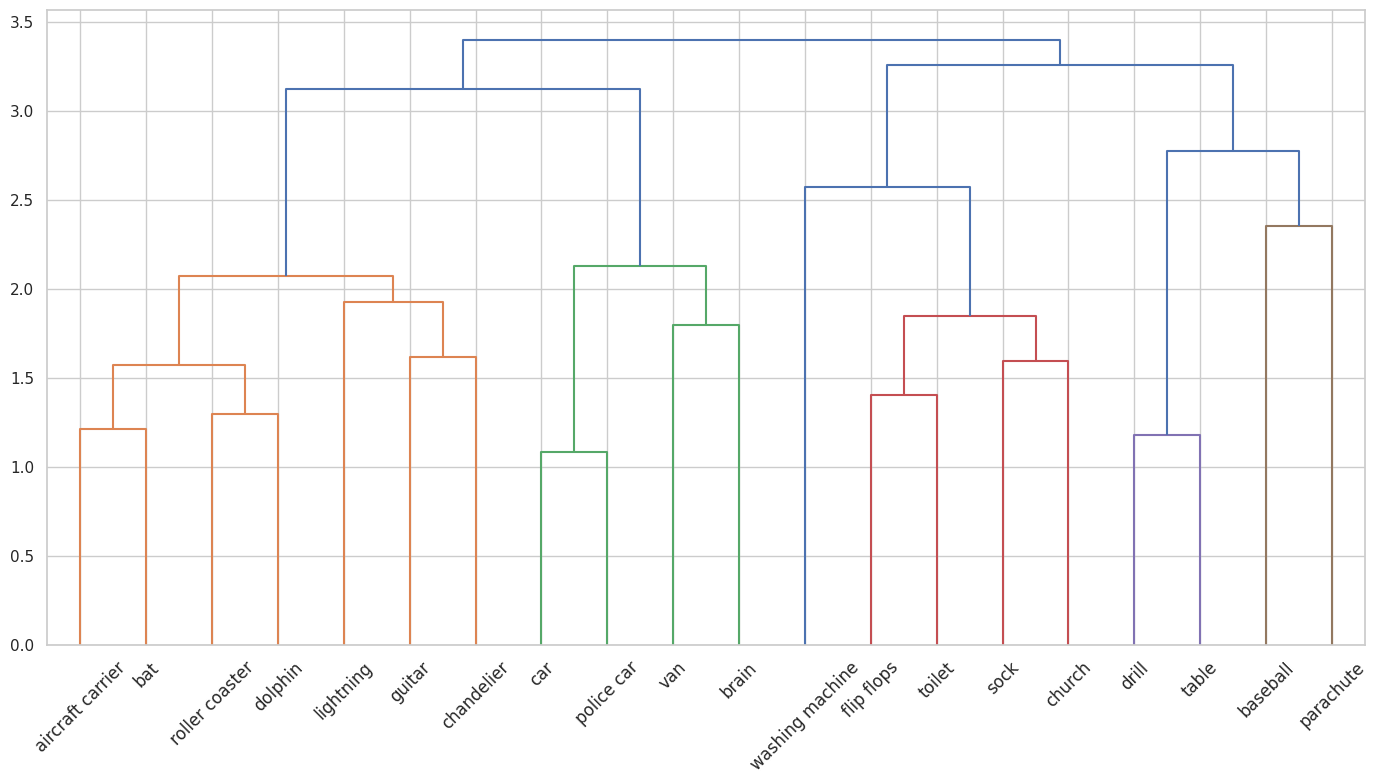

In [30]:
vae_model.eval()

all_latent_representations = []
all_labels = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.to(device)
        mu, logvar = vae_model.encode(data)
        all_latent_representations.append(mu.cpu().numpy())
        all_labels.append(labels.numpy())

latent_representations = np.concatenate(all_latent_representations, axis=0)
test_labels_np = np.concatenate(all_labels, axis=0)

print('======= Latent Space =======')
show_clusters(latent_representations, test_labels_np, sketch_categories)
show_dendrogram(latent_representations, test_labels_np, sketch_categories)

## Linear read-out layers

Linear layers are trained on top of the frozen VAE encoder to predict image classes

*LinearReadOutLayer* a simple linear transformation followed by a softmax activation for multi-class classification.

*LinearReadOutWrapper* a utility class that attaches the probe to specific depths of the VAE architecture.

Analyzing performance insights into how well the VAE has learned to separate classes at various depths of its architecture.

1. Layer 2 achieved the highest test accuracy which may indicate that the most linearly separable features are formed at this intermediate depth.

2. Certain confusions remain consistent across all depths, likely due to visual or semantic similarities in the sketches (e.g., vehicles like car, van, police car; guitar, chandelier, church; bat, roller coaster).

3. Early layers misclassify brain sketches as baseball or washing machine. This confusion decreases in deeper layers.

4. The model consistently excels at identifying table, parachute, and washing machine, probably due to their distinct geometric features.

In [19]:
class LinearReadOutLayer(nn.Module):
    def __init__(self, n_input, n_output=10) -> None:
        super(LinearReadOutLayer, self).__init__()

        self.linear = nn.Linear(n_input, n_output)

    def forward(self, x):
        return self.linear(x)


class LinearReadOutWrapper(nn.Module):
    def __init__(self, vae, linear_idx, n_output):
        super(LinearReadOutWrapper, self).__init__()

        self.vae = vae
        self.linear_idx = linear_idx

        # All linear layers of the encoder
        self.enc_linears = [m for m in vae.encoder if isinstance(m, nn.Linear)]
        all_probes = self.enc_linears + [vae.fc_mu]

        # Dimensions of the specific linear layer
        selected_layer = all_probes[linear_idx]
        n_input = selected_layer.out_features

        self.readout = LinearReadOutLayer(n_input, n_output)

        # Freezing VAE params
        for param in self.vae.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = x.view(x.size(0), -1)

        feat = x
        linear_count = 0

        for module in self.vae.encoder:
            feat = module(feat)
            if isinstance(module, nn.Linear):
                if linear_count == self.linear_idx:
                    return self.readout(feat)
                linear_count += 1

        feat = self.vae.fc_mu(feat)
        return self.readout(feat)

In [20]:
linear_layers = []

for layer_idx in range(num_linear_layers):
    linear_readout_wrapper = LinearReadOutWrapper(
        vae=vae_model,
        linear_idx=layer_idx,
        n_output=len(sketch_categories)
    ).to(device)

    linear_layers.append({
        'linear_readout': linear_readout_wrapper,
        'filename': f'linear_readout_{layer_idx+1}'
    })

In [28]:
for layer_idx, linear_layer_dict in enumerate(linear_layers):
    print(f'======= Layer {layer_idx + 1} =======')

    linear_readout_wrapper = linear_layer_dict['linear_readout']
    filename = linear_layer_dict['filename']

    train_model(
        model=linear_readout_wrapper,
        train_loader=train_loader,
        optimizer_cls=torch.optim.Adam,
        optimizer_params={'lr': 0.001},
        loss_fn=nn.CrossEntropyLoss(),
        epochs=100,
        device=device,
        filename=filename
    )

======= Layer 1 =======
Epoch 1/100, Loss: 0.0868
Epoch 11/100, Loss: 0.0709
Epoch 21/100, Loss: 0.0694
Epoch 31/100, Loss: 0.0715
Epoch 41/100, Loss: 0.0693
Epoch 51/100, Loss: 0.0688
Epoch 61/100, Loss: 0.0687
Epoch 71/100, Loss: 0.0690
Epoch 81/100, Loss: 0.0692
Epoch 91/100, Loss: 0.0691
Epoch 100/100, Loss: 0.0698
Model weights saved to "linear_readout_1.pth"
======= Layer 2 =======
Epoch 1/100, Loss: 0.0787
Epoch 11/100, Loss: 0.0639
Epoch 21/100, Loss: 0.0641
Epoch 31/100, Loss: 0.0633
Epoch 41/100, Loss: 0.0638
Epoch 51/100, Loss: 0.0631
Epoch 61/100, Loss: 0.0629
Epoch 71/100, Loss: 0.0622
Epoch 81/100, Loss: 0.0625
Epoch 91/100, Loss: 0.0624
Epoch 100/100, Loss: 0.0615
Model weights saved to "linear_readout_2.pth"
======= Layer 3 =======
Epoch 1/100, Loss: 0.0672
Epoch 11/100, Loss: 0.0506
Epoch 21/100, Loss: 0.0496
Epoch 31/100, Loss: 0.0502
Epoch 41/100, Loss: 0.0491
Epoch 51/100, Loss: 0.0489
Epoch 61/100, Loss: 0.0488
Epoch 71/100, Loss: 0.0485
Epoch 81/100, Loss: 0.0488


In [21]:
%%capture

# Downloading and loading weights from file
_loaded_linear_layers = []

for linear_layer_dict in linear_layers:
    linear_readout_wrapper = linear_layer_dict['linear_readout']
    filename = linear_layer_dict['filename']
    file_path = f'{filename}.pth'

    !wget -O {file_path} "https://raw.githubusercontent.com/pavelihno/cognition-computation-project/master/models/{file_path}"

    linear_readout_wrapper.load_state_dict(torch.load(file_path, map_location=device))
    linear_readout_wrapper.to(device)

    linear_layer_dict['linear_readout'] = linear_readout_wrapper
    _loaded_linear_layers.append(linear_layer_dict)

linear_layers = _loaded_linear_layers

In [22]:
def get_accuracy(model, test_loader, device=None):
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy


def show_confusion_matrix(model, test_loader, categories, device=None):
    model.to(device)
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=[c[0] for c in categories],
        yticklabels=[c[0] for c in categories]
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Layer 1: Test Accuracy: 0.4675


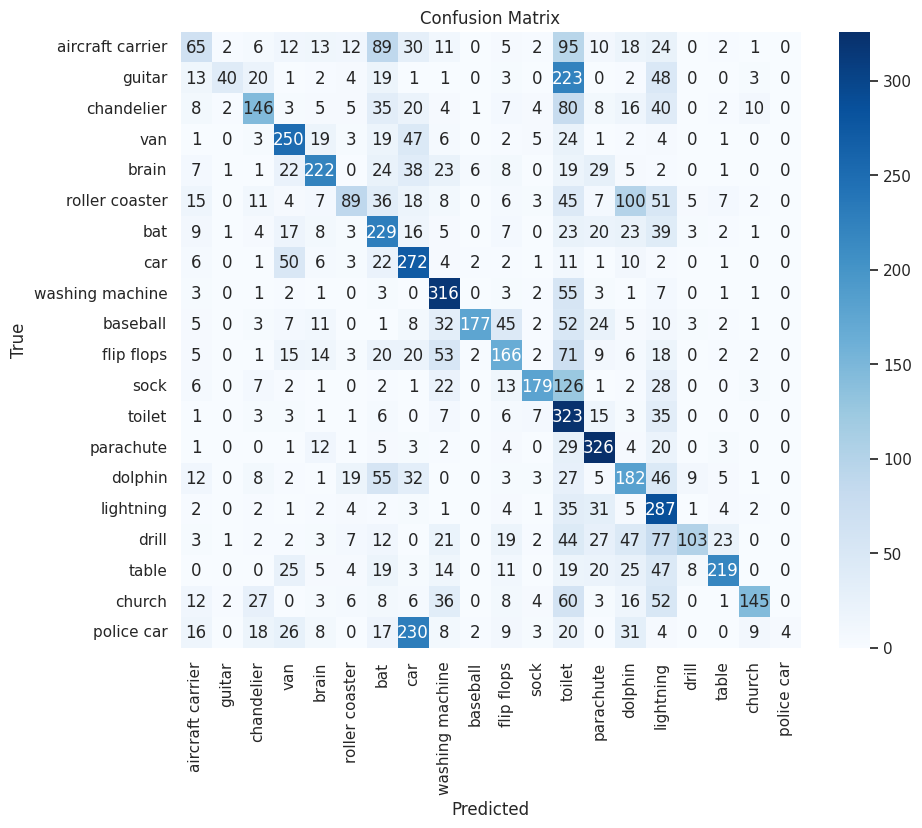

Layer 2: Test Accuracy: 0.5935


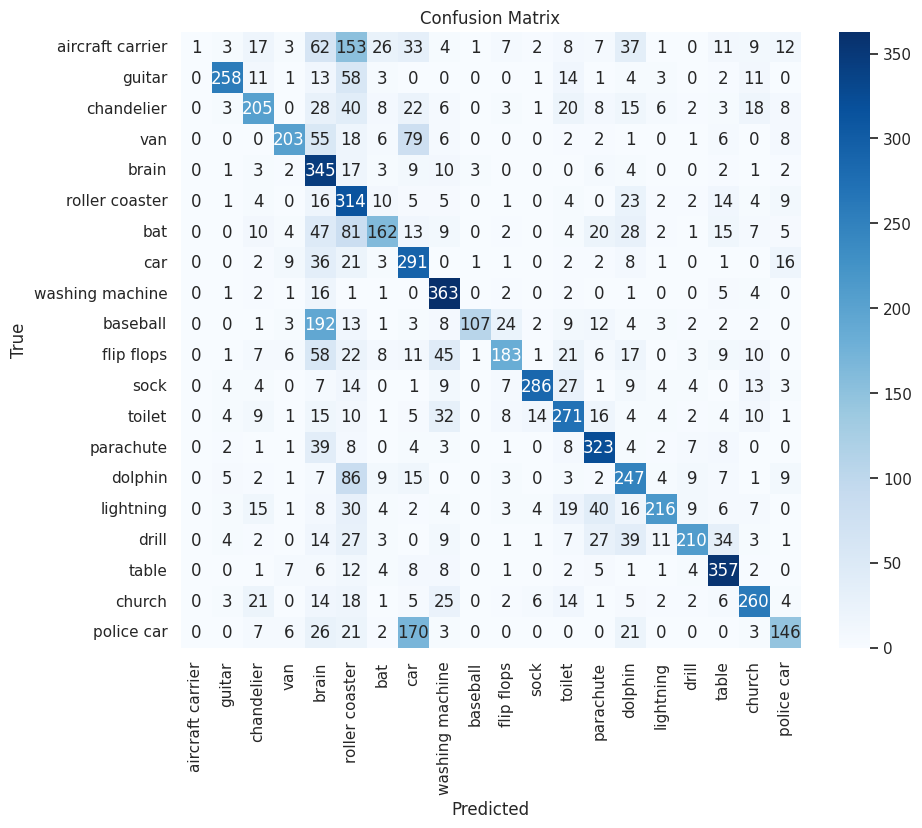

Layer 3: Test Accuracy: 0.5860


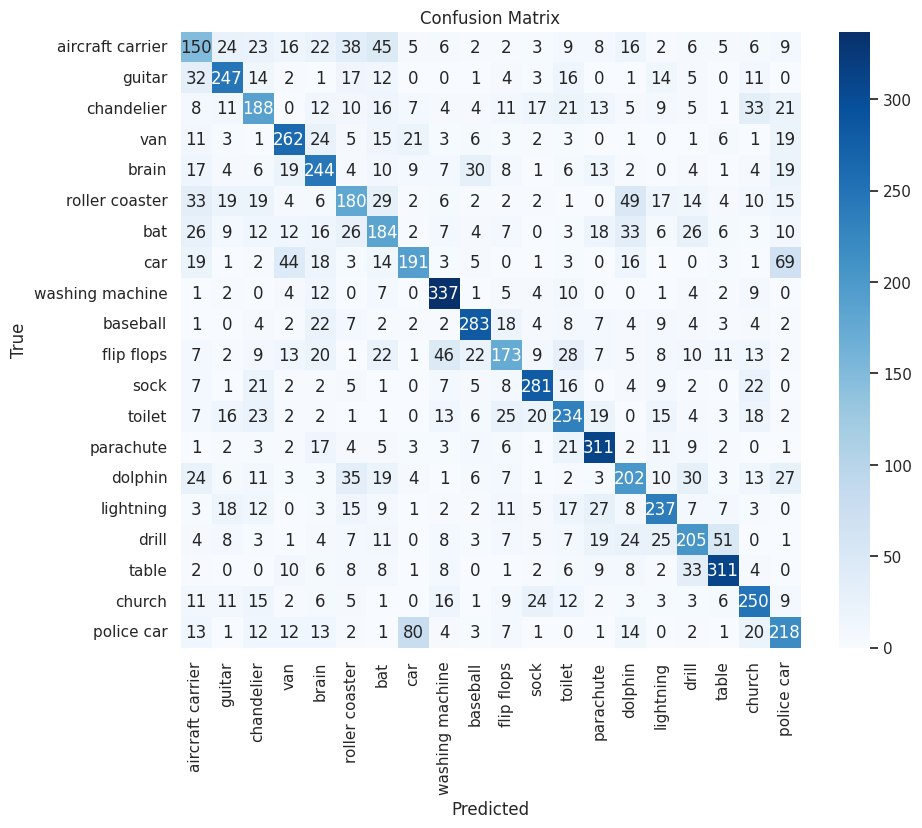

In [23]:
linear_accuracies = []

for layer_idx, linear_layer_dict in enumerate(linear_layers):
    linear_readout_wrapper = linear_layer_dict['linear_readout']

    accuracy = get_accuracy(
        model=linear_readout_wrapper,
        test_loader=test_loader,
        device=device
    )

    linear_accuracies.append(accuracy)

    print(f'Layer {layer_idx + 1}: Test Accuracy: {accuracy:.4f}')

    show_confusion_matrix(
        model=linear_readout_wrapper,
        test_loader=test_loader,
        categories=sketch_categories,
        device=device
    )

## Robustness to noise

In [24]:
def inject_noise(loader, train_flag=True, noise_level=0.1, device=None):
    all_noisy_data_batches = []
    all_label_batches = []

    for data, target in loader:
        data = data.to(device) if device is not None else data
        target = target.to(device) if device is not None else target

        noise = torch.randn_like(data) * noise_level

        noisy_data_batch = data + noise
        noisy_data_batch = torch.clamp(noisy_data_batch, 0., 1.)

        all_noisy_data_batches.append(noisy_data_batch)
        all_label_batches.append(target)

    noisy_data_tensor = torch.cat(all_noisy_data_batches, dim=0)
    labels_tensor = torch.cat(all_label_batches, dim=0)

    noisy_dataset = TensorDataset(noisy_data_tensor, labels_tensor)

    noisy_loader = DataLoader(
        noisy_dataset,
        batch_size=loader.batch_size,
        shuffle=train_flag
    )

    return noisy_loader


def plot_noise_robustness_curve(noise_levels, accuracy_values, label=None):
    plt.plot(
        noise_levels, accuracy_values, marker='o',
        linestyle='-', linewidth=2, label=label
    )
    plt.xlabel('Noise Level')
    plt.ylabel('Test Accuracy')
    plt.title('Model Robustness to Gaussian Noise')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.ylim(0, 1.05)

In [25]:
noise_levels = np.linspace(0, 2, 20)

linear_accuracies = defaultdict(list)

for noise_level in noise_levels:
    noise_loader = inject_noise(
        test_loader, noise_level=noise_level, train_flag=False, device=device
    )

    for layer_idx, linear_layer_dict in enumerate(linear_layers):
        linear_readout_wrapper = linear_layer_dict['linear_readout']
        _accuracy = get_accuracy(linear_readout_wrapper, noise_loader)
        linear_accuracies[noise_level].append(_accuracy)

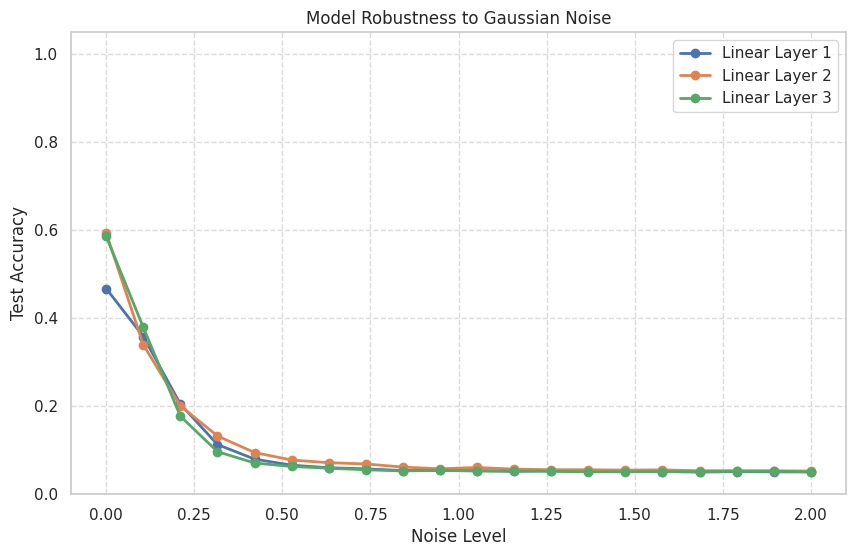

In [26]:
plt.figure(figsize=(10, 6))

lin_acc_np = np.array([linear_accuracies[level] for level in noise_levels])

num_layers = lin_acc_np.shape[1]
for i in range(num_layers):
    plot_noise_robustness_curve(
        noise_levels,
        lin_acc_np[:, i],
        label=f'Linear Layer {i+1}'
    )

plt.legend(loc='best')
plt.show()

## Adversarial attacks